In [1]:
#!pip install matplotlib

In [2]:
#!pip install seaborn

In [3]:
#!pip install -U scikit-learn

In [4]:
#!pip install opencv-python

In [ ]:
#!pip install h5py

In [ ]:
#!pip install pydot

In [ ]:
#!pip install graphviz

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style= "darkgrid", color_codes = True)
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input
from keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.preprocessing.image import  load_img
import warnings
import glob
import cv2
import pandas as pd
from sklearn.metrics import classification_report
warnings.filterwarnings('ignore')
import h5py
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
#import pickle

In [6]:
print(tf.__version__)
#tf.test.is_gpu_available()
tf.config.list_physical_devices('GPU')

2.10.1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
# Define image size and other parameters
img_width, img_height = 256, 256
batchsize = 32
epochs = 4
num_of_class = 2

validation = keras.utils.image_dataset_from_directory(
    directory='Resources/val',
    labels='inferred',
    label_mode='categorical',
    batch_size=batchsize,
    # color_mode='grayscale',
    image_size=(img_width, img_height),
    seed=123)

Found 16 files belonging to 2 classes.


In [8]:
test = keras. utils.image_dataset_from_directory(
    directory='Resources/test',
    labels='inferred',
    label_mode='categorical',
    batch_size=batchsize,
    # color_mode='grayscale',
    image_size=(img_width, img_height),
    seed=123)

Found 624 files belonging to 2 classes.


In [9]:
train = keras. utils.image_dataset_from_directory(
    directory='Resources/train',
    labels='inferred',
    label_mode='categorical',
    batch_size=batchsize,
    # color_mode='grayscale',
    image_size=(img_width, img_height),
    seed=123)

Found 5216 files belonging to 2 classes.


In [10]:
print(train.class_names)
print(validation.class_names)
print(test.class_names)

['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']


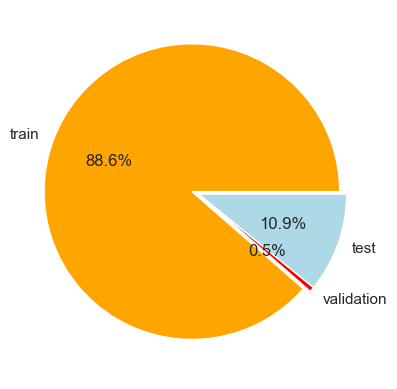

In [11]:
plt.pie([len(train), len(validation), len(test)],
        labels=['train', 'validation', 'test'], autopct='%.1f%%', colors=['orange', 'red', 'lightblue'], explode=(0.05, 0, 0))
plt.show()

In [12]:
x_train = []
y_train = []

for feature, label in train:
    x_train.append(feature.numpy())
    y_train.append(label.numpy())

x_train = np.concatenate(x_train, axis=0)
y_train_np = np.concatenate(y_train, axis=0)

#y_train_df=pd.DataFrame(y_train, columns=['Normal', 'Pneumonia'])
#y_train_np=y_train_df['Pneumonia'].to_numpy()

In [13]:
#x_train_sample=x_train[0:100]
#y_train_sample=y_train_np[0:100]

In [14]:
x_val = []
y_val = []
    
for feature, label in validation:
    x_val.append(feature.numpy())
    y_val.append(label.numpy())

x_val = np.concatenate(x_val, axis=0)
y_val_np = np.concatenate(y_val, axis=0)

#y_val_df=pd.DataFrame(y_val, columns=['Normal', 'Pneumonia'])
#y_val_np=y_val_df['Pneumonia'].to_numpy()

Class names: ['NORMAL', 'PNEUMONIA']
Image batch shape: (16, 256, 256, 3)
Label batch shape: (16, 2)
Labels (one-hot): [[0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


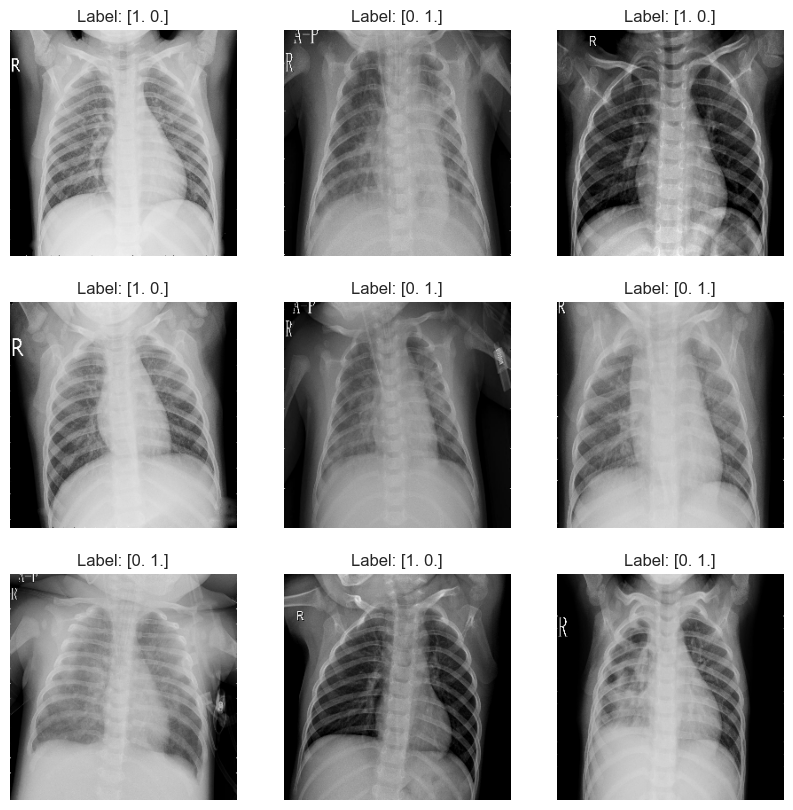

In [15]:
class_names = validation.class_names
print("Class names:", class_names)
for images, labels in validation.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    print("Labels (one-hot):", labels.numpy())
# Step 5: Display some images and their one-hot encoded labels
plt.figure(figsize=(10, 10))
for images, labels in validation.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
plt.show()

In [16]:
x_test = []
y_test = []

for feature, label in test:
    x_test.append(feature.numpy())
    y_test.append(label.numpy())

x_test = np.concatenate(x_test, axis=0)
y_test_np = np.concatenate(y_test, axis=0)

#y_test_df=pd.DataFrame(y_test, columns=['Normal', 'Pneumonia'])
#y_test_np=y_test_df['Pneumonia'].to_numpy()

In [17]:
# check the shapes of 'x_train' and 'y_train':
print("Shape of 'x_train':", x_train.shape)
print("Shape of 'y_train_np':", y_train_np.shape)
print("Shape of 'x_val':", x_val.shape)
print("Shape of 'y_val_np':", y_val_np.shape)
print("Shape of 'x_test':", x_test.shape)
print("Shape of 'y_test_np':", y_test_np.shape)

Shape of 'x_train': (5216, 256, 256, 3)
Shape of 'y_train_np': (5216, 2)
Shape of 'x_val': (16, 256, 256, 3)
Shape of 'y_val_np': (16, 2)
Shape of 'x_test': (624, 256, 256, 3)
Shape of 'y_test_np': (624, 2)


In [18]:
x_train=x_train/255
x_val=x_val/255
x_test=x_test/255

In [25]:
# We use transfer learning with VGG16 as the base model
def CNN_Model():
    base_model = VGG16(weights='imagenet', include_top = False, input_shape=(img_width, img_height, 3))
    # Freeze the base model
    for layer in base_model.layers:
        layer.trainable = False
    for i in range(3):
        base_model.layers[-2-i].trainable = True
    CNN = Sequential()
    CNN.add(Input(shape=(img_width, img_height,3)))
    CNN.add(base_model)
    CNN.add(Flatten())
    CNN.add(Dropout(0.3))
    CNN.add(Dense(128, activation='relu', kernel_regularizer=l2(0.05)))
    CNN.add(Dropout(0.2))
    CNN.add(Dense(2, activation='sigmoid'))
    return CNN
# Training The CNN
model = CNN_Model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
#Visualized Layers of CNN
#keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dropout (Dropout)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 128)               4194432   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 18,909,378
Trainable params: 11,274,114
No

In [26]:
hist = model.fit(x_train, y_train_np, epochs= 6, validation_data= (x_val, y_val_np))
print(hist.history)
best_score = max(hist.history['val_accuracy'])
print(f"Best Validation score is: {best_score}")

Epoch 1/6
163/163 [==============================] - 26s 108ms/step - loss: 1.2701 - accuracy: 0.8545 - val_loss: 0.2389 - val_accuracy: 1.0000
Epoch 2/6
163/163 [==============================] - 16s 98ms/step - loss: 0.2883 - accuracy: 0.9536 - val_loss: 0.2715 - val_accuracy: 1.0000
Epoch 3/6
163/163 [==============================] - 15s 95ms/step - loss: 0.1716 - accuracy: 0.9732 - val_loss: 0.2744 - val_accuracy: 0.8125
Epoch 4/6
163/163 [==============================] - 15s 92ms/step - loss: 0.1060 - accuracy: 0.9826 - val_loss: 0.4996 - val_accuracy: 0.8125
Epoch 5/6
163/163 [==============================] - 16s 99ms/step - loss: 0.0890 - accuracy: 0.9854 - val_loss: 0.0370 - val_accuracy: 1.0000
Epoch 6/6
163/163 [==============================] - 17s 103ms/step - loss: 0.0776 - accuracy: 0.9858 - val_loss: 0.0813 - val_accuracy: 1.0000
{'loss': [1.270118236541748, 0.28827613592147827, 0.17155508697032928, 0.10598557442426682, 0.0889768972992897, 0.07764710485935211], 'accur

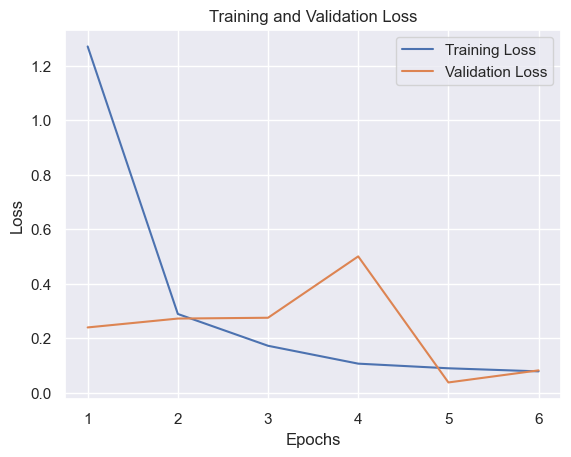

In [27]:
# Extract the training and validation loss values from the history object
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

# Create a list of epoch numbers (1 to number of epochs)
epochs = range(1, len(train_loss) + 1)

# Plot the loss graph
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

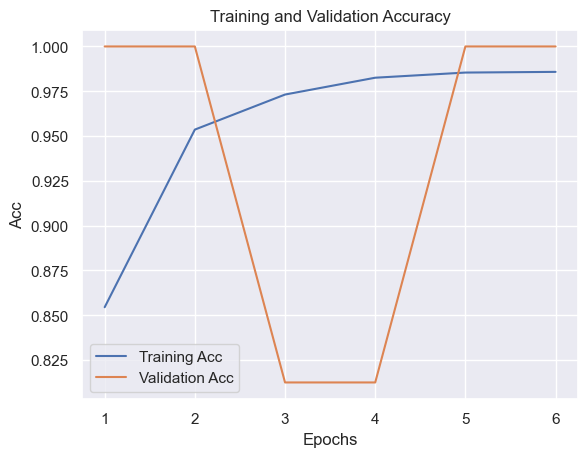

In [30]:
# Extract the training and validation loss values from the history object
train_accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

# Create a list of epoch numbers (1 to number of epochs)
epochs = range(1, len(train_accuracy) + 1)

# Plot the loss graph
plt.plot(epochs, train_accuracy , label='Training Acc')
plt.plot(epochs, val_accuracy, label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
model.evaluate(x_test, y_test_np)

20/20 [==============================] - 2s 89ms/step - loss: 1.5038 - accuracy: 0.7420


[1.5038045644760132, 0.7419871687889099]

In [33]:
x_test_predict=model.predict(x_test)
print(x_test_predict.shape)
pred_final=np.argmax(x_test_predict,axis=1)
print(pred_final.shape)
print(pred_final)

20/20 [==============================] - 2s 84ms/step
(624, 2)
(624,)
[0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1
 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 0 1 1 0 1 0 1 1 0 1 1 0 1 1 0 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1
 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [ ]:
pred_final

In [31]:
img_test=[]
label_test=[]
for image_batch,label_batch in test:
  img_test.append(image_batch)
  label_test.append(label_batch)
inputs_test=np.concatenate(img_test)
targets_test=np.concatenate(label_test)
print(inputs_test.shape)
print(targets_test.shape)
print(targets_test)

(624, 256, 256, 3)
(624, 2)
[[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [1. 0.]]


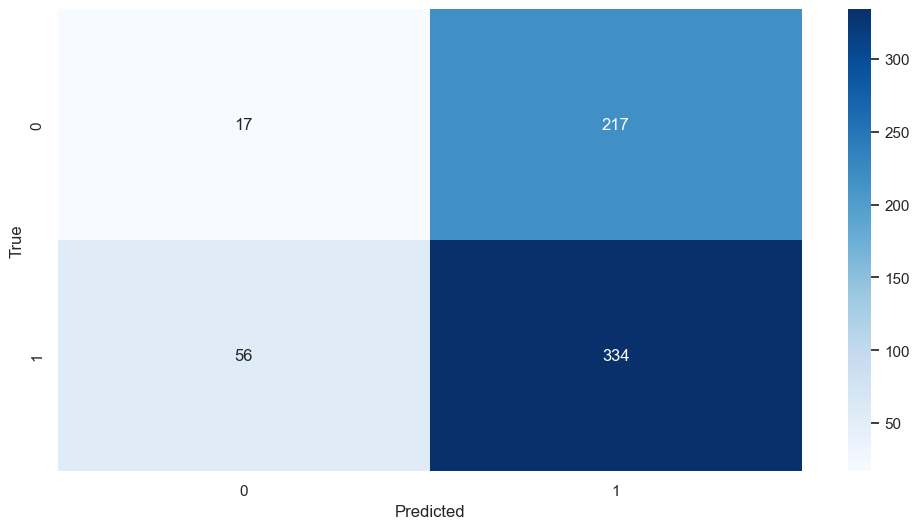

In [34]:
# Convert predictions to class indices if necessary
if pred_final.ndim > 1 and pred_final.shape[1] > 1:
    pred_final = np.argmax(pred_final, axis=1)

# Ensure targets_test is in the correct format
# (It should already be, but double-check to avoid errors)
if targets_test.ndim > 1 and targets_test.shape[1] > 1:
    targets_test = np.argmax(targets_test, axis=1)

# Generate a confusion matrix for the test dataset
cm = tf.math.confusion_matrix(labels=targets_test, predictions=pred_final)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=[12, 6])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()